# The Moon made of a mesh.
Tutorial by [RnD Team](https://rnd.team).

The Moon elevation model is a great example of a large data sample that is not trivial to display at once with a generic approach. There are samples 8GB/22GB of data in 118m/59m resolution available. We'll try to visualize it in two ways: preparing a triangular mesh with nodes for each data point (this notebook), and using the data as a displacement map applied to the sphere ([here](https://github.com/rnd-team-dev/plotoptix/blob/master/examples/3_projects/moon/making_the_moon__displacement.ipynb)). Read the [article](....) for all details.

![moon ray_traced](https://plotoptix.rnd.team/images/moon_2res_banner.jpg "The Moon ray-traced")

This notebook implements visualization of the Moon surface color and elevation data using the triangular mesh. The mesh approach is fast, especially on Turing GPU's supporting hardware acceleration of finding the ray-triangle intersections. However, storing all the triangular mesh data: vertices, normals, and their indices can fill the GPU memory quickly. See the [other approach](https://github.com/rnd-team-dev/plotoptix/blob/master/examples/3_projects/moon/making_the_moon__displacement.ipynb) for making much more detailed Moon at the cost of the computation time.

- to run this notebook locally, in Linux or Windows: follow [PlotOptiX installation](https://plotoptix.rnd.team/home.html#installation) steps;
- to run on a [Google Cloud Platform](https://cloud.google.com), follow [these instructions](....).

## 1. Collect data files.

### Surface elevation.

The Moon surface elevation model is based on data from the Lunar Orbiter Laser Altimeter (LOLA). Data is provided by LOLA Science Team in [118m resolution](https://astrogeology.usgs.gov/search/details/Moon/LRO/LOLA/Lunar_LRO_LOLA_Global_LDEM_118m_Mar2014/cub) (used in this notebook), and by LOLA/Kaguya Team in [59m resolution](https://astrogeology.usgs.gov/search/map/Moon/LRO/LOLA/Lunar_LRO_LOLAKaguya_DEMmerge_60N60S_512ppd), if you'd like to go for a crazy detailed Moon. Data is stored as a single image file, in 16-bit grayscale TIFF format so you need a good tool to read this into the memory and do some preprocessing. 

### Surface color.

The high-resolution color data comes from [Lunar Reconnaissance Orbiter Camera (LROC)](http://lroc.sese.asu.edu/posts/801). The polar regions I completed with lower resolution textures. Color details are most important when viewed from the light source direction. It is less significant with the side lighting when the shadows of the terrain bring out much more details.

### Stars.

We'll use a map in celestial coordinates from NASA, available at https://svs.gsfc.nasa.gov/3895. Credit goes to:

NASA/Goddard Space Flight Center Scientific Visualization Studio. Constellation figures based on those developed for the IAU by Alan MacRobert of Sky and Telescope magazine (Roger Sinnott and Rick Fienberg).

The highest resolution star map is 16k. We'll get that one and downscale it as needed. It is only a decoration for our Moon visualization so let's not make it the main factor filling the GPU memory. Though the stars and Milky Way are real and the environment texture looks best at the highest resolution.

In [1]:
import os, urllib.request
from plotoptix.install import download_file_from_google_drive

if not os.path.isdir("data"): os.mkdir("data")

# surface elevation (8GB, can take a while!)
elevation_file = "data/Lunar_LRO_LOLA_Global_LDEM_118m_Mar2014.tif"
if not os.path.isfile(elevation_file):
    print("Downloading elevation data...")
    url = "http://planetarymaps.usgs.gov/mosaic/Lunar_LRO_LOLA_Global_LDEM_118m_Mar2014.tif"
    urllib.request.urlretrieve (url, elevation_file)

# surface color (71MB)
color_file = "data/moon_color_10k_8bit.tif"
if not os.path.isfile(color_file):
    print("Downloading color data...")
    fid = "1gJeVic597BUAkpz1GgCYRMJVninKEDKB"
    download_file_from_google_drive(fid, color_file)

# stars (132MB)
starmap_file = "data/starmap_16k.tif"
if not os.path.isfile(starmap_file):
    print("Downloading star map...")
    url = "https://svs.gsfc.nasa.gov/vis/a000000/a003800/a003895/starmap_16k.tif"
    urllib.request.urlretrieve (url, starmap_file)

print("Data is ready.")

Data is ready.


## 2. Prepare data.

Which is basically: downscale data to what your hardware can handle. For making a standard, triangular mesh, each point on the Moon surface needs 3D coordinates (3x 4-byte single-precision values), a normal vector (again 3x 4-byte values), index (8 triangles using each point, so 8x 4-byte integer value), color (4x 4-byte value). That's a lot, one can squeeze in only about 15M mesh points / 1GB of the GPU memory... and there must be some space left for the stars in the background and for the output buffers... We're going to downscale a lot.

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import cv2

from plotoptix.utils import read_image

### Elevation data

Images of *n*GB size are not possible to read with OpenCV. PlotOptiX's utils can manage such huge files: image is decoded directly into numpy's ndarray.

In [3]:
elev_src = read_image(elevation_file)
if elev_src is not None:
    print("Dimensions:", elev_src.shape)
    print("Data type:", elev_src.dtype)
    print("Size: %.2f GB" % (elev_src.nbytes / (1024**3)))
else: print("Failed on the image reading.")

Dimensions: (46080, 92160)
Data type: uint16
Size: 7.91 GB


**Downscale factor:** let's start with x20, this works with 6GB GPU's; lower the value if you have more memory.

In [4]:
downscale = 20

In [5]:
elev_src.dtype = np.int16
scale = 1. / np.iinfo(np.int16).max

h = elev_src.shape[0] // downscale
w = elev_src.shape[1] // downscale

elevation = elev_src.reshape(1, h, downscale, w, downscale).mean(4, dtype=np.float32).mean(2, dtype=np.float32).reshape(h, w)
elevation *= scale

elev_src = None

print("Dimensions:", elevation.shape)
print("Data type:", elevation.dtype)
print("Size: %.2f GB" % (elevation.nbytes / (1024**3)))

Dimensions: (576, 1152)
Data type: float32
Size: 0.00 GB


<IPython.core.display.Javascript object>


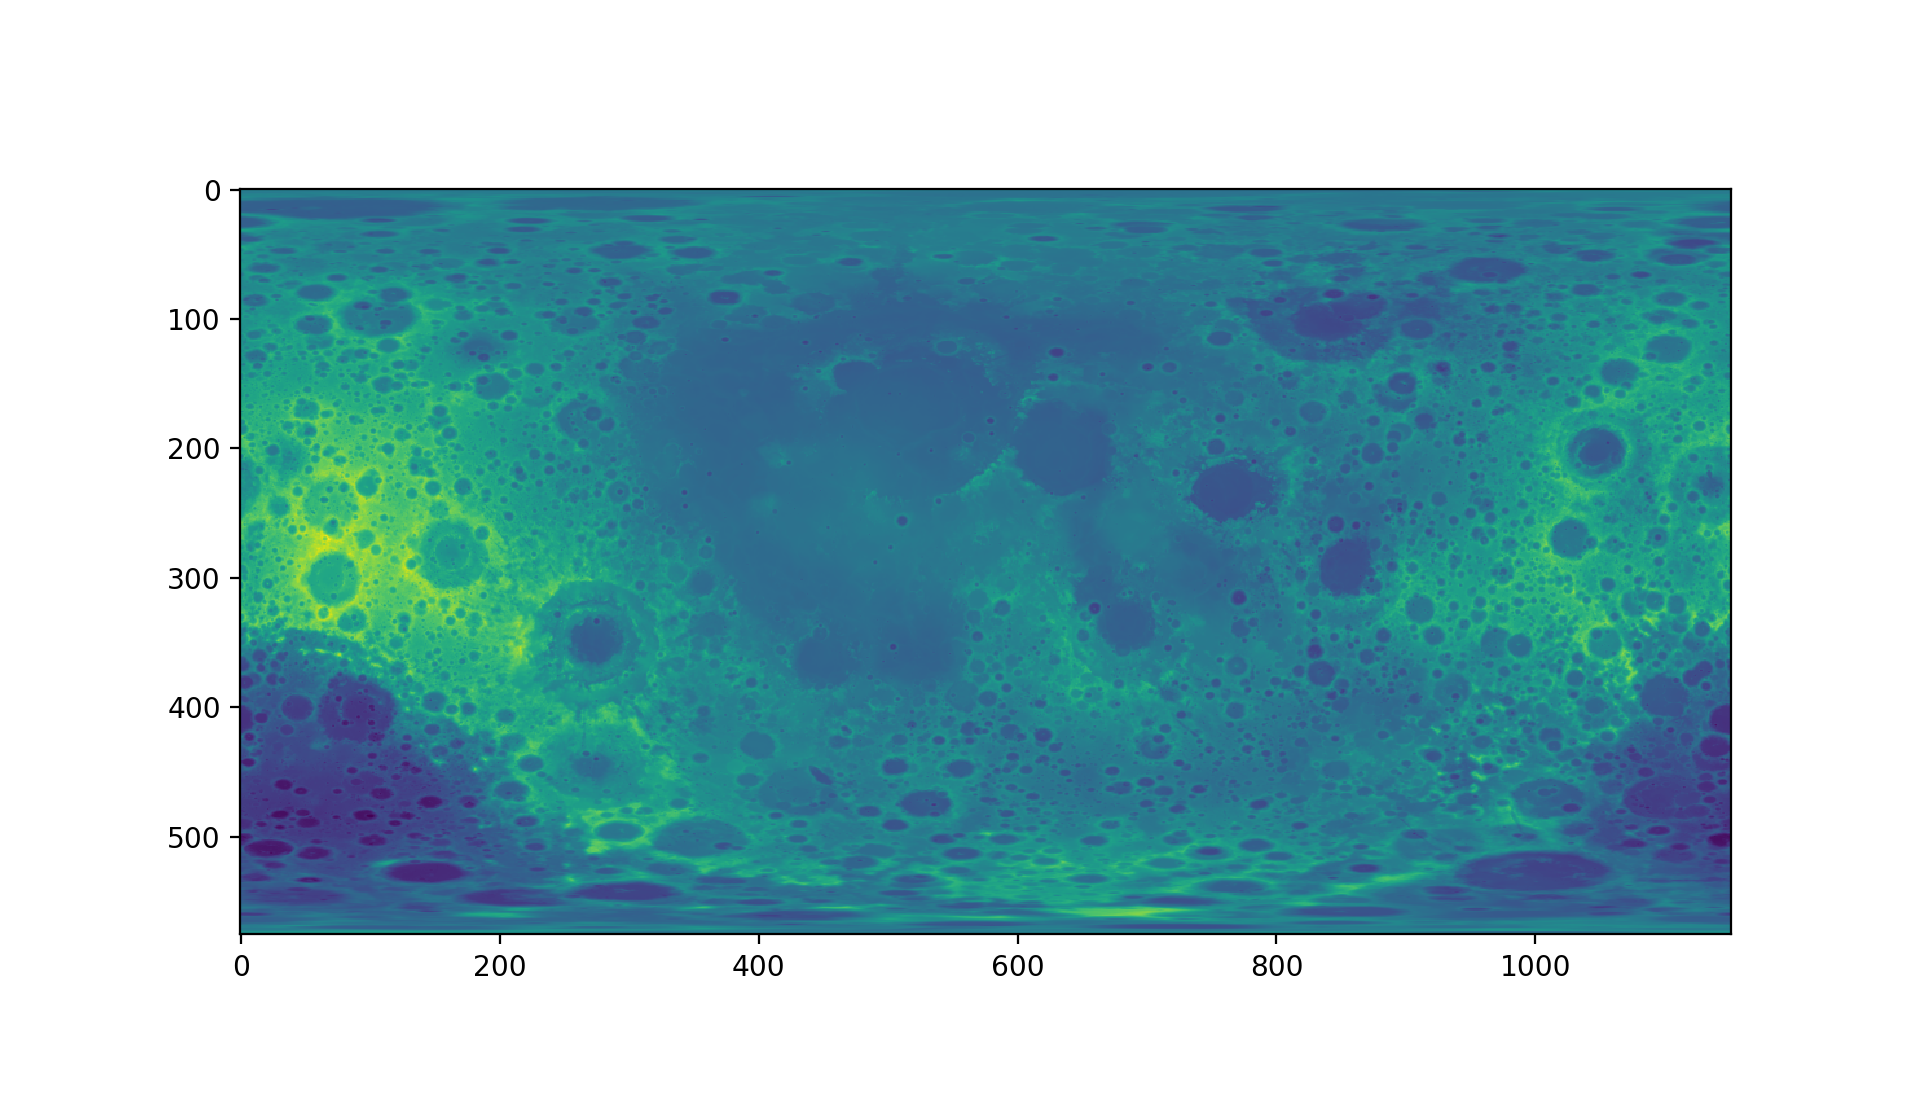

In [6]:
plt.figure(1, figsize=(9.5, 5.5))
plt.tight_layout()
imgplot = plt.imshow(elevation)

### Surface color map.

Resize color data to match the elevation array shape, scale color values to ``[0; 1]`` range (add some margin on both, shadows and highlights, for a better look of the ray-traced image).

<IPython.core.display.Javascript object>


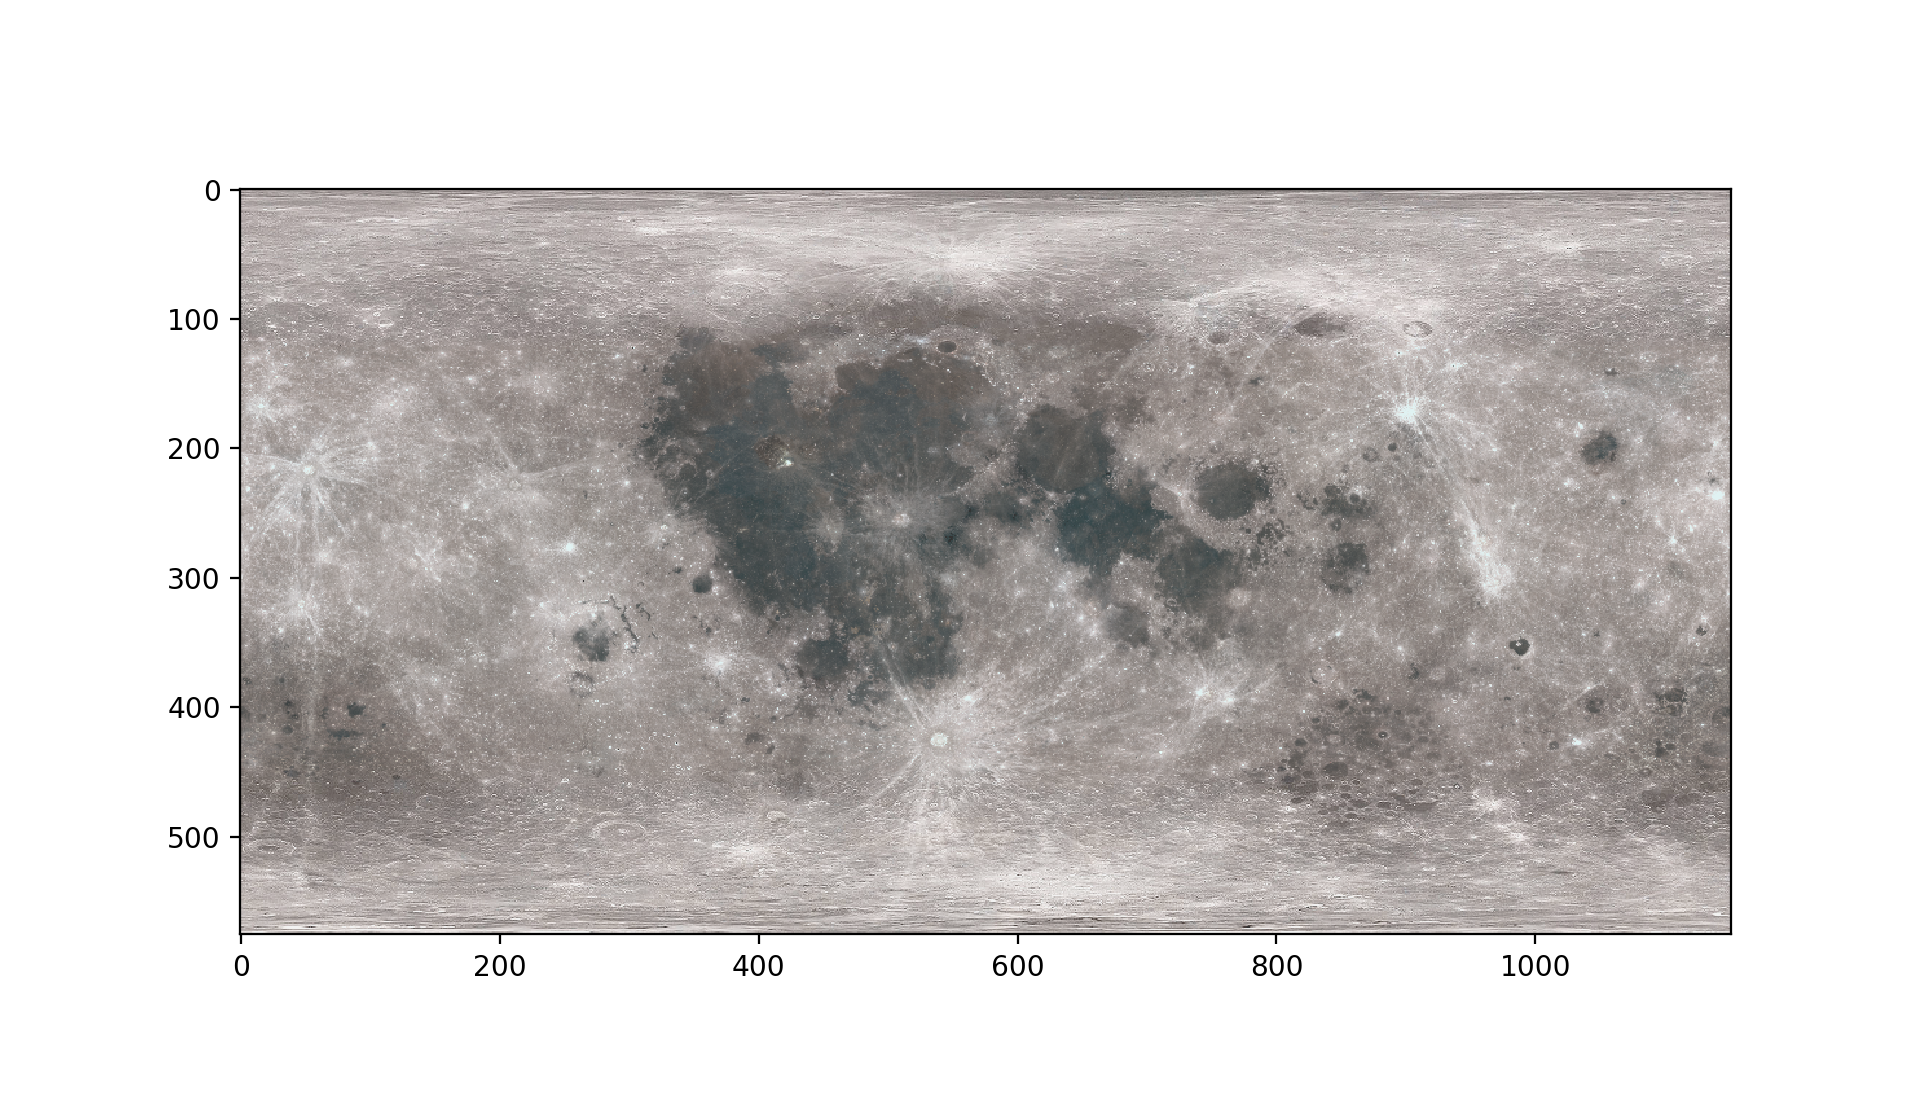

Dimensions: (576, 1152, 3)
Data type: float32
Size: 0.01 GB


In [7]:
color_src = cv2.imread(color_file)
color_src = color_src[..., ::-1].astype(np.float32) # convert from BGR to RGB, 32bit floating point
color_src = 0.2 + (0.75 / 255) * color_src

color_map = cv2.resize(color_src, dsize=elevation.shape[::-1], interpolation=cv2.INTER_CUBIC).astype(np.float32)
np.clip(color_map, 0, 1, out=color_map) # clamp out-of-range interpolation results

color_src = None

plt.figure(2, figsize=(9.5, 5.5))
plt.tight_layout()
color_plot = plt.imshow(color_map)

print("Dimensions:", color_map.shape)
print("Data type:", color_map.dtype)
print("Size: %.2f GB" % (color_map.nbytes / (1024**3)))

### Star map.

Read and resize the image to the size reasonable for your GPU.

<IPython.core.display.Javascript object>


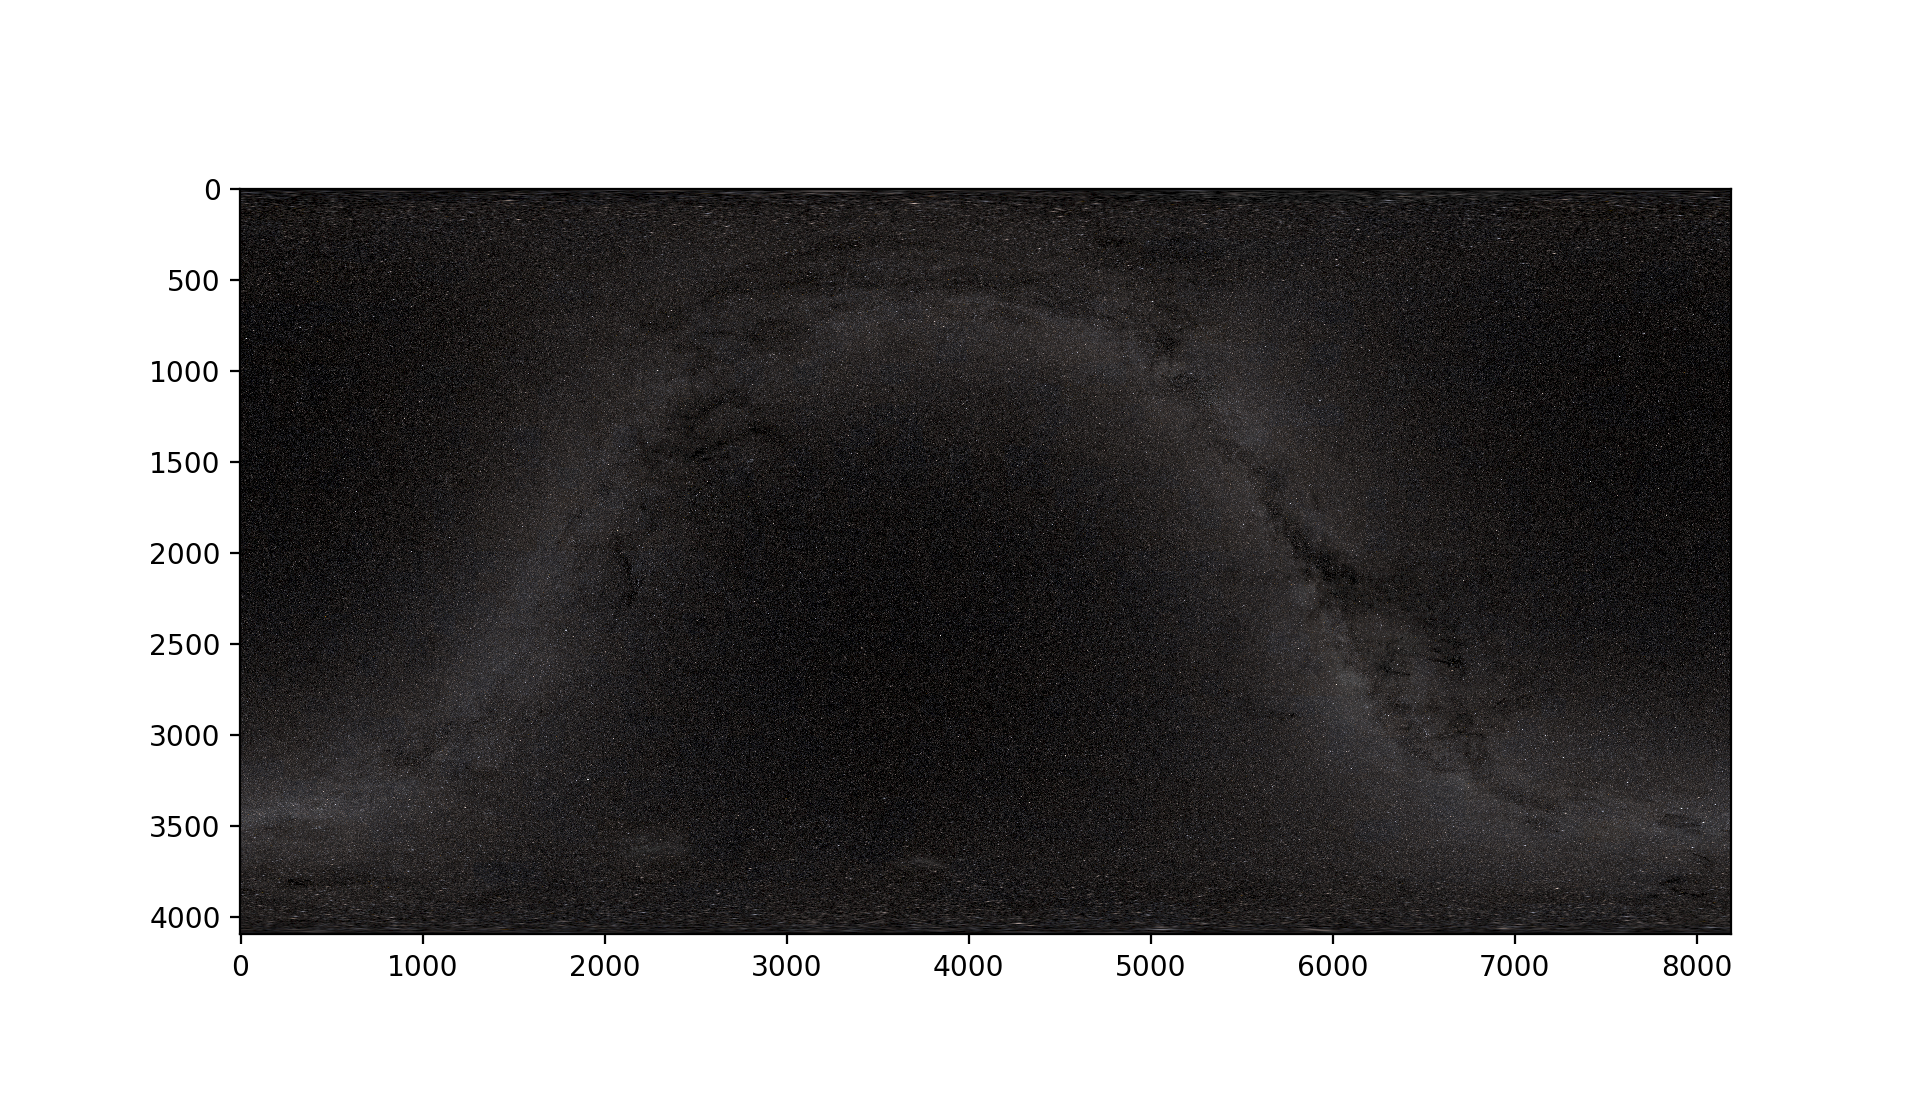

Dimensions: (4096, 8192, 3)
Data type: float32
Size: 0.38 GB


In [8]:
star_map_width = 8192 # target for downscaling from the original 16k width

star_src = cv2.imread(starmap_file)
star_src = star_src[..., ::-1].astype(np.float32) # convert from BGR to RGB, 32bit floating point
star_src = (1 / 255) * star_src

if star_map_width < star_src.shape[1]:
    star_map_height = int(star_src.shape[0] * star_map_width / star_src.shape[1])
    star_map_size = (star_map_width, star_map_height)
    star_map = cv2.resize(star_src, dsize=star_map_size, interpolation=cv2.INTER_CUBIC).astype(np.float32)
    np.clip(star_map, 0, 1, out=star_map) # clamp out-of-range interpolation results
    star_src = None
else:
    star_map = star_src

plt.figure(3, figsize=(9.5, 5.5))
plt.tight_layout()
color_plot = plt.imshow(np.sqrt(star_map)) # plot sqrt to boost faint lights

print("Dimensions:", star_map.shape)
print("Data type:", star_map.dtype)
print("Size: %.2f GB" % (star_map.nbytes / (1024**3)))

### Calculate a spherical mesh nodes, modulated with the elevation data.

Note the small size of the 3D nodes data. It is the normal vectors, color data, and the triangle nodes+indices all together that blows the memory fast.

In [9]:
def sphere(iu, iv, ie, scale_u, scale_v, r):
    r *= ie
    u = scale_u * iu
    v = scale_v * iv
    sinu = np.sin(u)
    return r * np.array([sinu * np.cos(v), sinu * np.sin(v), np.cos(u)], dtype=np.float32)

iu = np.arange(elevation.shape[0])
iv = np.arange(elevation.shape[1])
V, U = np.meshgrid(iv, iu)

ku = np.pi / elevation.shape[0]
kv = 2 * np.pi / elevation.shape[1]

rmin = np.min(elevation)
rmax = np.max(elevation)
rv = rmax - rmin

# rescale "in place": 0.98 + (0.02/rv)*(elevation+rmin)
elevation += rmin
elevation *= 0.02 / rv
elevation += 0.98

S = sphere(U, V, elevation, ku, kv, 10).T

iu = iv = U = V = elevation = None

print("Dimensions:", S.shape)
print("Data type:", S.dtype)
print("Size: %.2f GB" % (S.nbytes / (1024**3)))

Dimensions: (1152, 576, 3)
Data type: float32
Size: 0.01 GB


## 3. Setup ray-tracing with PlotOptiX.

See PlotOptiX [documentation](https://plotoptix.rnd.team) and [examples](https://github.com/rnd-team-dev/plotoptix/tree/master/examples) to learn more about ray tracing with this tool.

In [10]:
from plotoptix import TkOptiX
from plotoptix.utils import make_color_2d

In [11]:
optix = TkOptiX(width=1100, height=750)         # create Tkinter-based ray tracing output

optix.set_param(min_accumulation_step=2,        # 2 accumulation frames / image refresh
                max_accumulation_frames=100)    # accumulate 100 frames to remove noise

exposure = 0.9; gamma = 2.2                     # add tonal correction
optix.set_float("tonemap_exposure", exposure)
optix.set_float("tonemap_igamma", 1 / gamma)
optix.add_postproc("Gamma")

optix.set_background_mode("TextureEnvironment") # star map in the background
optix.set_background(star_map, gamma=gamma)

Add mesh data to the scene.

In [12]:
optix.set_surface("surface", S,
                  c=np.swapaxes(make_color_2d(color_map, gamma=gamma), 0, 1),
                  wrap_v=True,
                  make_normals=True)

Setup camera, lights, and start ray tracing.

In [13]:
optix.setup_camera("cam1", cam_type="DoF",
                   eye=[-13, -22, 3], target=[0, 0, 0], up=[0, 0.9, 0.5],
                   aperture_radius=0.06, aperture_fract=0.2,
                   focal_scale=0.62, fov=55)

optix.setup_light("sun", pos=[-50, 0, 0], color=60, radius=6)

optix.start()

Change the view.

In [15]:
# zoom in, note the mesh triangles
optix.update_camera("cam1", fov=5)

In [18]:
# fly close over the surface, more details would be nice!
optix.update_camera("cam1",
                    eye=[-3.44, -9.37, 1.67], target=[-4.61, -8.24, 1.55], up=[-1, -0.02, 0.05],
                    aperture_radius=0.005, focal_scale=0.92, fov=45)

In [16]:
# and another angle...
optix.update_camera("cam1",
                    eye=[-0.01, -6.02, 9.96], target=[-4.01, -3.75,  7.66], up=[-1, 0.07, 0.22],
                    aperture_radius=0.05, focal_scale=0.74, fov=33)

Have a fun and explore the Moon. Save your favorite view to a file.

In [14]:
optix.save_image("moon_mesh.jpg")

Close the ray tracing session.

In [20]:
optix.close()

### Thanks for running!

Hope you enjoyed the Moon. Try also the [displacement map](https://github.com/rnd-team-dev/plotoptix/blob/master/examples/3_projects/moon/making_the_moon__displacement.ipynb) approach.

Visit us on [RnD Team](https://rnd.team) home page, or join us on social media: [Facebook](https://www.facebook.com/rndteam), [Behance](https://www.behance.net/RnDTeam) and [Instagram](https://www.instagram.com/rnd.team.studio).